In [1]:
import os

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from tqdm.autonotebook import tqdm

In [2]:
class HandLandmarksDataset(Dataset):
    def __init__(self, imgs: np.ndarray):
        self.imgs = imgs

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        arr = self.imgs[idx]
        return torch.tensor(arr[:-1], dtype=torch.float32), torch.tensor(arr[-1], dtype=torch.int64)

In [3]:
class GestureClassifier(nn.Module):
    def __init__(self, num_classes=14):
        super(GestureClassifier, self).__init__()

        # Fully connected layers
        self.fc1 = nn.Linear(42, 128)  # 21 * 2
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)  # 14 classes for the gestures

    def forward(self, x):
        # x = x.view(-1, 21 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
data = np.load("processed.npy")
data.shape

(918, 43)

In [5]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_data.shape, test_data.shape

((826, 43), (92, 43))

(array([ 8.,  5.,  5.,  5.,  5., 10.,  5.,  6.,  6.,  7.,  8.,  9.,  8.,
         5.]),
 array([ 0.        ,  0.92857143,  1.85714286,  2.78571429,  3.71428571,
         4.64285714,  5.57142857,  6.5       ,  7.42857143,  8.35714286,
         9.28571429, 10.21428571, 11.14285714, 12.07142857, 13.        ]),
 <BarContainer object of 14 artists>)

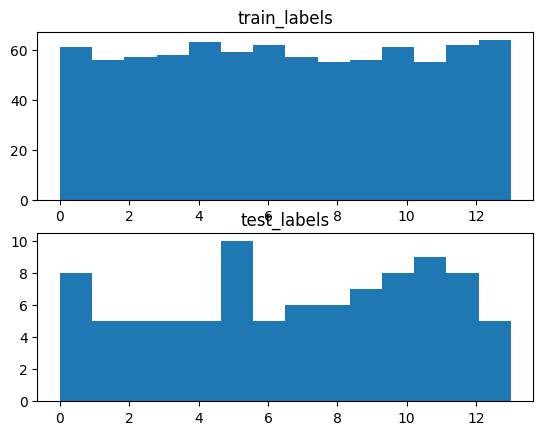

In [6]:
fix, ax = plt.subplots(2)

ax[0].set_title("train_labels")
ax[0].hist([arr[-1] for arr in train_data], bins=14)

ax[1].set_title("test_labels")
ax[1].hist([arr[-1] for arr in test_data], bins=14)

In [7]:
BATCH_SIZE = 8
# Create the dataset and dataloader
train_dataset = HandLandmarksDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = HandLandmarksDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Load the model and define the loss and optimizer
model = GestureClassifier()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
train_dataset[100]

(tensor([ 0.0000,  0.0000,  0.1723, -0.0576,  0.3348, -0.2590,  0.4425, -0.4545,
          0.5449, -0.5635,  0.2280, -0.5501,  0.2593, -0.6714,  0.2212, -0.4619,
          0.1871, -0.3378,  0.1087, -0.5744,  0.1330, -0.6580,  0.1142, -0.4073,
          0.1036, -0.3183, -0.0070, -0.5612,  0.0019, -0.6583,  0.0158, -0.4363,
          0.0265, -0.3289, -0.1170, -0.5246, -0.1560, -0.7294, -0.1811, -0.8455,
         -0.2042, -1.0000]),
 tensor(9))

In [9]:
def train(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=10, batch_size=32, device=torch.device("cpu")
):
    # Train the model
    train_predicted = []
    train_labels = []
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        # Set the model to training mode
        model.train()

        # Initialize running loss and accuracy
        running_loss = 0.0
        running_accuracy = 0.0

        # Train on the batches in the training set
        pbar = tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{num_epochs}")
        for i, (inputs, labels) in enumerate(pbar):
            # Send the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass and backward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Update the running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            running_accuracy += torch.sum(predicted == labels).item()

            train_predicted.extend(predicted.tolist())
            train_labels.extend(labels.tolist())

        # Compute the average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_dataset)
        epoch_accuracy = running_accuracy / len(train_dataset)
        epoch_f1 = f1_score(train_labels, train_predicted, average="macro")

        # Print the training loss and accuracy for the epoch
        print(f"Train Epoch {epoch+1}: Loss={epoch_loss:.4f}, Accuracy={epoch_accuracy:.4f}, F1={epoch_f1:.4f}")

        # Set the model to evaluation mode
        model.eval()

        # Initialize test loss and accuracy
        test_loss = 0.0
        test_accuracy = 0.0

        # Evaluate on the batches in the test set
        with torch.no_grad():
            pbar = tqdm(test_loader, desc=f"Test Epoch {epoch+1}/{num_epochs}")

            test_predicted = []
            test_labels = []
            for i, (inputs, labels) in enumerate(pbar):
                # Send the inputs and labels to the device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute the loss and accuracy
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                test_accuracy += torch.sum(predicted == labels).item()

                test_predicted.extend(predicted.tolist())
                test_labels.extend(labels.tolist())

        # Compute the average test loss and accuracy for the epoch
        test_loss /= len(test_dataset)
        test_accuracy /= len(test_dataset)
        test_f1 = f1_score(test_labels, test_predicted, average="macro")

        # Print the test loss and accuracy for the epoch
        print(f"Test Epoch {epoch+1}: Loss={test_loss:.4f}, Accuracy={test_accuracy:.4f}, F1={test_f1:.4f}")

In [14]:
train(model, train_loader, test_loader, criterion, optimizer, num_epochs=7)

Epochs:   0%|          | 0/7 [00:00<?, ?it/s]

Train Epoch 1/7:   0%|          | 0/104 [00:00<?, ?it/s]

Train Epoch 1: Loss=0.2595, Accuracy=0.9467, F1=0.9467


Test Epoch 1/7:   0%|          | 0/12 [00:00<?, ?it/s]

Test Epoch 1: Loss=0.2845, Accuracy=0.9348, F1=0.9361


Train Epoch 2/7:   0%|          | 0/104 [00:00<?, ?it/s]

Train Epoch 2: Loss=0.2511, Accuracy=0.9298, F1=0.9382


Test Epoch 2/7:   0%|          | 0/12 [00:00<?, ?it/s]

Test Epoch 2: Loss=0.2968, Accuracy=0.9022, F1=0.9019


Train Epoch 3/7:   0%|          | 0/104 [00:00<?, ?it/s]

Train Epoch 3: Loss=0.2232, Accuracy=0.9467, F1=0.9411


Test Epoch 3/7:   0%|          | 0/12 [00:00<?, ?it/s]

Test Epoch 3: Loss=0.2328, Accuracy=0.9565, F1=0.9505


Train Epoch 4/7:   0%|          | 0/104 [00:00<?, ?it/s]

Train Epoch 4: Loss=0.2113, Accuracy=0.9467, F1=0.9425


Test Epoch 4/7:   0%|          | 0/12 [00:00<?, ?it/s]

Test Epoch 4: Loss=0.2655, Accuracy=0.9457, F1=0.9453


Train Epoch 5/7:   0%|          | 0/104 [00:00<?, ?it/s]

Train Epoch 5: Loss=0.1939, Accuracy=0.9492, F1=0.9439


Test Epoch 5/7:   0%|          | 0/12 [00:00<?, ?it/s]

Test Epoch 5: Loss=0.3328, Accuracy=0.8913, F1=0.8954


Train Epoch 6/7:   0%|          | 0/104 [00:00<?, ?it/s]

Train Epoch 6: Loss=0.1953, Accuracy=0.9552, F1=0.9458


Test Epoch 6/7:   0%|          | 0/12 [00:00<?, ?it/s]

Test Epoch 6: Loss=0.1978, Accuracy=0.9674, F1=0.9635


Train Epoch 7/7:   0%|          | 0/104 [00:00<?, ?it/s]

Train Epoch 7: Loss=0.1927, Accuracy=0.9588, F1=0.9476


Test Epoch 7/7:   0%|          | 0/12 [00:00<?, ?it/s]

Test Epoch 7: Loss=0.2765, Accuracy=0.9239, F1=0.9247


In [11]:
torch.save(model, "model.pth")

In [12]:
import onnx
import tensorflow as tf
from onnx_tf.backend import prepare


def pytorch_to_tensorflowlight(model: GestureClassifier, model_name: str = "gesture"):
    dummy_input = torch.randn(1, 21 * 2)

    input_names = ["actual_input_1"] + ["learned_%d" % i for i in range(6)]
    output_names = ["output1"]

    onnx_name = model_name + ".onnx"

    torch.onnx.export(model, dummy_input, onnx_name, verbose=True, input_names=input_names, output_names=output_names)

    onnx_model = onnx.load(onnx_name)
    tf_rep = prepare(onnx_model)

    tf_rep.export_graph(model_name)

    # Convert the model
    converter = tf.lite.TFLiteConverter.from_saved_model(model_name)  # path to the SavedModel directory
    tflite_model = converter.convert()

    # Save the model.
    with open(f"{model_name}.tflite", "wb") as f:
        f.write(tflite_model)

2023-04-15 19:37:21.614138: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-15 19:37:21.672424: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 19:37:22.574125: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/samoed/.pyenv/versions/3.10.4/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and relea

In [13]:
pytorch_to_tensorflowlight(model)

Exported graph: graph(%actual_input_1 : Float(1, 42, strides=[42, 1], requires_grad=0, device=cpu),
      %learned_0 : Float(128, 42, strides=[42, 1], requires_grad=1, device=cpu),
      %learned_1 : Float(128, strides=[1], requires_grad=1, device=cpu),
      %learned_2 : Float(64, 128, strides=[128, 1], requires_grad=1, device=cpu),
      %learned_3 : Float(64, strides=[1], requires_grad=1, device=cpu),
      %learned_4 : Float(14, 64, strides=[64, 1], requires_grad=1, device=cpu),
      %learned_5 : Float(14, strides=[1], requires_grad=1, device=cpu)):
  %/fc1/Gemm_output_0 : Float(1, 128, strides=[128, 1], requires_grad=1, device=cpu) = onnx::Gemm[alpha=1., beta=1., transB=1, onnx_name="/fc1/Gemm"](%actual_input_1, %learned_0, %learned_1), scope: __main__.GestureClassifier::/torch.nn.modules.linear.Linear::fc1 # /home/samoed/.pyenv/versions/3.10.4/lib/python3.10/site-packages/torch/nn/modules/linear.py:114:0
  %/Relu_output_0 : Float(1, 128, strides=[128, 1], requires_grad=1, device

2023-04-15 19:37:23.672927: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-15 19:37:23.770643: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:Assets written to: gesture/assets


INFO:tensorflow:Assets written to: gesture/assets
2023-04-15 19:37:25.126065: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-04-15 19:37:25.126093: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-04-15 19:37:25.126997: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: gesture
2023-04-15 19:37:25.127371: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-04-15 19:37:25.127382: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: gesture
2023-04-15 19:37:25.128351: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-04-15 19:37:25.128645: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-04-15 19:37:25.158174: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle a